In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import matplotlib.dates as mdates
from datetime import datetime
import xarray as xr
import netCDF4 as nc
import pandas as pd
import glob
import math
import subprocess
from matplotlib import colormaps

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
ds_mc3e_1mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/old_1_2mom/1_mom/NWP_LAM_DOM04_20110511T*Z.nc")
ds_mc3e_2mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/old_1_2mom/2_mom/NWP_LAM_DOM04_20110511T*Z.nc")
grid_mc3e = xr.open_dataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_input/grids/R3B10/domain4_DOM04.nc")



In [3]:
clon_deg = np.degrees(grid_mc3e.clon)
clat_deg = np.degrees(grid_mc3e.clat)

print(clon_deg.min().values); print(clon_deg.max().values);
print(clat_deg.min().values); print(clat_deg.max().values);

-100.03562402798536
-93.96330271276062
31.965389663179398
38.035332298302436


In [4]:
okla_x, okla_y = np.array([-98., 37.])
okla_x, okla_y = np.array([-98., 37.])
#print(okla_x), print(okla_y)
dx_deg = 1.; dy_deg = 1.0
left_bound = okla_x - dx_deg
right_bound = okla_x + dx_deg
top_bound = okla_y + dy_deg
bottom_bound = okla_y - dy_deg

print(left_bound), print(right_bound)
print(top_bound), print(bottom_bound)

-99.0
-97.0
38.0
36.0


(None, None)

In [5]:
window_cell = (
    (grid_mc3e.clat >= np.deg2rad(bottom_bound))
    & (grid_mc3e.clat <= np.deg2rad(top_bound))
    & (grid_mc3e.clon >= np.deg2rad(left_bound))
    & (grid_mc3e.clon <= np.deg2rad(right_bound))
).values

(window_cell_indices,) = np.where(window_cell)


In [6]:
# select cells matching with the area of interest (windows_cell_indices:: matching to that with the area sampled by the aircraft)
window_vertex_indices = (np.unique(grid_mc3e.vertex_of_cell.isel(cell=window_cell_indices).values) - 1)
window_vertex_indices

array([   23,    67,   148, ..., 62065, 62069, 62074], dtype=int32)

In [7]:
# select edges matching with the area of interest (corresponding to the windows_cell_indices)
window_edge_indices = (np.unique(grid_mc3e.edge_of_cell.isel(cell=window_cell_indices).values) - 1)
window_edge_indices

array([   699,   1112,   1135, ..., 175964, 175965, 175966], dtype=int32)

In [8]:
selected_indices = xr.Dataset(
    {
        "cell": ("cell", window_cell_indices),
        "vertex": ("vertex", window_vertex_indices),
        "edge": ("edge", window_edge_indices),
    }
)

#print(selected_indices.cell)
#print(selected_indices.vertex)
#print(selected_indices.edge)

In [9]:
vars_to_renumber = {
    "cell": [
        "adjacent_cell_of_edge",
        "cells_of_vertex",
        "neighbor_cell_index",
    ],
    "vertex": ["vertex_of_cell", "edge_vertices", "vertices_of_vertex"],
    "edge": ["edge_of_cell", "edges_of_vertex"],
}

In [10]:
def reindex_grid(grid, indices, vars_to_renumber):
    new_grid = grid.load().isel(
        cell=indices.cell, vertex=indices.vertex, edge=indices.edge
    )
    for dim, idx in indices.coords.items():
        renumbering = np.full(grid.dims[dim], -2, dtype="int")
        renumbering[idx] = np.arange(len(idx))
        for name in vars_to_renumber[dim]:
            new_grid[name].data = renumbering[new_grid[name].data - 1] + 1
    return new_grid

In [11]:
new_grid_mc3e = reindex_grid(grid_mc3e, selected_indices, vars_to_renumber)


In [12]:
mask=np.isin(ds_mc3e_1mom.dbz['ncells'], selected_indices.cell)

In [13]:
ds_mc3e_1mom_new = ds_mc3e_1mom.sel(ncells=mask)
ds_mc3e_2mom_new = ds_mc3e_2mom.sel(ncells=mask)

In [14]:
time_1mom = ds_mc3e_1mom_new['time'];
qv_1mom = ds_mc3e_1mom_new['qv'];
qc_1mom = ds_mc3e_1mom_new['qc'];
qi_1mom = ds_mc3e_1mom_new['qi'];
qs_1mom = ds_mc3e_1mom_new['qs'];
qr_1mom = ds_mc3e_1mom_new['qr'];
prec_1mom = ds_mc3e_1mom_new['tot_prec'];
temp_1mom = ds_mc3e_1mom_new['temp'];
dbz_1mom = ds_mc3e_1mom_new['dbz'];
ht_1mom = ds_mc3e_1mom_new['z_mc'];
rho_1mom = ds_mc3e_1mom_new['rho'];
pres_1mom = ds_mc3e_1mom_new['pres'];
omega_1mom = ds_mc3e_1mom_new['omega'];
vert_vel_1mom = -1.*omega_1mom/(9.8*rho_1mom);

# 2 moment
time_2mom = ds_mc3e_2mom_new['time'];
qv_2mom = ds_mc3e_2mom_new['qv'];
qc_2mom = ds_mc3e_2mom_new['qc'];
qi_2mom = ds_mc3e_2mom_new['qi'];
qs_2mom = ds_mc3e_2mom_new['qs'];
qr_2mom = ds_mc3e_2mom_new['qr'];
prec_2mom = ds_mc3e_2mom_new['tot_prec'];
temp_2mom = ds_mc3e_2mom_new['temp'];
dbz_2mom = ds_mc3e_2mom_new['dbz'];
ht_2mom = ds_mc3e_2mom_new['z_mc'];
rho_2mom = ds_mc3e_2mom_new['rho'];
pres_2mom = ds_mc3e_2mom_new['pres'];
omega_2mom = ds_mc3e_2mom_new['omega'];
vert_vel_2mom = -1.*omega_2mom/(9.8*rho_2mom);

In [15]:
thres_q = 1.e-6;
thres_w_min = 2.
thres_w_max = 15.
thres_w = 2.
#(vert_vel_1mom > thres_w_min) & (vert_vel_1mom < thres_w_max)

#################################### 1 moment ######################################

filt_qv_1mom = xr.where((qv_1mom > thres_q), qv_1mom, np.nan)
filt_qc_1mom = xr.where((qc_1mom > thres_q) & (vert_vel_1mom > thres_w), qc_1mom, np.nan)
filt_qi_1mom = xr.where((qi_1mom > thres_q) & (vert_vel_1mom > thres_w), qi_1mom, np.nan)
filt_qs_1mom = xr.where((qs_1mom > thres_q) & (vert_vel_1mom > thres_w), qs_1mom, np.nan)
filt_qr_1mom = xr.where((qr_1mom > thres_q) & (vert_vel_1mom > thres_w), qr_1mom, np.nan)
filt_dbz_1mom = xr.where((dbz_1mom > -10.), dbz_1mom, np.nan)

avg_qv_1mom = filt_qv_1mom.mean(dim=('time','ncells'))
avg_qc_1mom = filt_qc_1mom.mean(dim=('time','ncells'))
avg_qi_1mom = filt_qi_1mom.mean(dim=('time','ncells'))
avg_qs_1mom = filt_qs_1mom.mean(dim=('time','ncells'))
avg_qr_1mom = filt_qr_1mom.mean(dim=('time','ncells'))

avg_dbz_1mom = filt_dbz_1mom.mean(dim=('time','ncells'))
avg_temp_1mom = temp_1mom.mean(dim=('time','ncells'))
avg_ht_1mom = ht_1mom.mean(dim=('time','ncells'))
avg_pres_1mom = pres_1mom.mean(dim=('time','ncells'))

lwc_1mom = filt_qc_1mom*rho_1mom*1.e3 # kgperm3 to gperm3
iwc_1mom = filt_qi_1mom*rho_1mom*1.e3 # kgperm3 to gperm3
avg_lwc_1mom = lwc_1mom.mean(dim=('time','ncells'))
avg_iwc_1mom = iwc_1mom.mean(dim=('time','ncells'))
avg_tempc_1mom = avg_temp_1mom-273.16; 

##################################### 2 moment ########################################

filt_qv_2mom = xr.where((qv_2mom > thres_q), qv_2mom, np.nan)
filt_qc_2mom = xr.where((qc_2mom > thres_q) & (vert_vel_2mom > thres_w), qc_2mom, np.nan)
filt_qi_2mom = xr.where((qi_2mom > thres_q) & (vert_vel_2mom > thres_w), qi_2mom, np.nan)
filt_qs_2mom = xr.where((qs_2mom > thres_q) & (vert_vel_2mom > thres_w), qs_2mom, np.nan)
filt_qr_2mom = xr.where((qr_2mom > thres_q) & (vert_vel_2mom > thres_w), qr_2mom, np.nan)
filt_dbz_2mom = xr.where((dbz_2mom > -10.), dbz_2mom, np.nan)

avg_qv_2mom = filt_qv_2mom.mean(dim=('time','ncells'))
avg_qc_2mom = filt_qc_2mom.mean(dim=('time','ncells'))
avg_qi_2mom = filt_qi_2mom.mean(dim=('time','ncells'))
avg_qs_2mom = filt_qs_2mom.mean(dim=('time','ncells'))
avg_qr_2mom = filt_qr_2mom.mean(dim=('time','ncells'))

avg_dbz_2mom = filt_dbz_2mom.mean(dim=('time','ncells'))
avg_temp_2mom = temp_2mom.mean(dim=('time','ncells'))
avg_ht_2mom = ht_2mom.mean(dim=('time','ncells'))
avg_pres_2mom = pres_2mom.mean(dim=('time','ncells'))

lwc_2mom = filt_qc_2mom*rho_2mom*1.e3 # kgperm3 to gperm3
iwc_2mom = filt_qi_2mom*rho_2mom*1.e3 # kgperm3 to gperm3
avg_lwc_2mom = lwc_2mom.mean(dim=('time','ncells'))
avg_iwc_2mom = iwc_2mom.mean(dim=('time','ncells'))
avg_tempc_2mom = avg_temp_2mom-273.16; 


In [16]:
print(avg_lwc_2mom.values)

[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 0.33629394 1.0190308  1.0853813  1.1473609  1.1463884
 1.1703904  1.1929377  1.2085023  1.2287678  1.2450144  1.2514975
 1.2535924  1.2424883  1.2251558  1.1975614  1.1598788  1.1104931
 1.0618758  1.0083972  0.95398104 0.90424746 0.8630844  0.8267137
 0.7914001  0.7657763  0.74687576 0.7313532  0.7090705  0.6999539
 0.6865604  0.6671043  0.6463807  0.618689   0.5903111  0.55315834
 0.51070756 0.47048014 0.41970024 0.3633099  0.28164154 0.22662792
 0.15167685 0.17254384        nan        nan        nan        nan
        nan        nan        nan        nan        nan]


In [18]:
# Observations
# Initialize empty lists for each column for droplet mean diameter

temp_obs_cdp = []
num_drop_cdp = []
std_dev_num_drop_cdp = []
std_err_num_drop_cdp = []

temp_obs_cdp = []
lwc_cdp = []
std_dev_lwc_cdp = []
std_err_lwc_cdp = []

with open('/work/bb1163/b382718/output/mc3e/observations/FORTRAN_CODE/ICE_CONC_VERTICAL_PROFILE/UPDRAFT/OUTPUT/drop_num_conc_cdp_percm3', 'r') as file:
    # Read each line
    for line in file:
        # Split the line into columns (assuming columns are separated by whitespace)
        columns = line.split()
        # Store each column in its corresponding list
        temp_obs_cdp.append(float(columns[0]))
        num_drop_cdp.append(float(columns[1]))
        std_dev_num_drop_cdp.append(float(columns[2]))
        std_err_num_drop_cdp.append(float(columns[3]))

with open('/work/bb1163/b382718/output/mc3e/observations/FORTRAN_CODE/ICE_CONC_VERTICAL_PROFILE/UPDRAFT/OUTPUT/lwc_cdp_gperm3', 'r') as file:
    # Read each line
    for line in file:
        # Split the line into columns (assuming columns are separated by whitespace)
        columns = line.split()
        # Store each column in its corresponding list
        #temp_obs_cdp.append(float(columns[0]))
        lwc_cdp.append(float(columns[1]))
        std_dev_lwc_cdp.append(float(columns[2]))
        std_err_lwc_cdp.append(float(columns[3]))
        
#### CDP CDNC
temp_obs_cdp = np.array(temp_obs_cdp)
num_drop_cdp = np.array(num_drop_cdp)
std_dev_num_drop_cdp = np.array(std_dev_num_drop_cdp)
std_err_num_drop_cdp = np.array(std_err_num_drop_cdp)

num_drop_cdp[(num_drop_cdp <= 0)] = np.nan

#### CDP CDNC
temp_obs_cdp = np.array(temp_obs_cdp)
lwc_cdp = np.array(lwc_cdp)
std_dev_lwc_cdp = np.array(std_dev_lwc_cdp)
std_err_lwc_cdp = np.array(std_err_lwc_cdp)

lwc_cdp[(lwc_cdp <= 0)] = np.nan

#####################################################################
temp_obs = []
num_ice_cip = []
std_dev_num_ice_cip = []
std_err_num_ice_cip = []

num_ice_comb = []
std_dev_num_ice_comb = []
std_err_num_ice_comb = []

num_ice_hvps = []
std_dev_num_ice_hvps = []
std_err_num_ice_hvps = []
# Open the text file
with open('/work/bb1163/b382718/output/mc3e/observations/FORTRAN_CODE/ICE_CONC_VERTICAL_PROFILE/UPDRAFT/OUTPUT/ice_num_conc_cip_percm3', 'r') as file:
    # Read each line
    for line in file:
        # Split the line into columns (assuming columns are separated by whitespace)
        columns = line.split()
        # Store each column in its corresponding list
        temp_obs.append(float(columns[0]))
        num_ice_cip.append(float(columns[1]))
        std_dev_num_ice_cip.append(float(columns[2]))
        std_err_num_ice_cip.append(float(columns[3]))

with open('/work/bb1163/b382718/output/mc3e/observations/FORTRAN_CODE/ICE_CONC_VERTICAL_PROFILE/UPDRAFT/OUTPUT/ice_num_conc_comb_percm3', 'r') as file:
    # Read each line
    for line in file:
        # Split the line into columns (assuming columns are separated by whitespace)
        columns = line.split()
        # Store each column in its corresponding list
        #temp_obs.append(float(columns[0]))
        num_ice_comb.append(float(columns[1]))
        std_dev_num_ice_comb.append(float(columns[2]))
        std_err_num_ice_comb.append(float(columns[3]))

with open('/work/bb1163/b382718/output/mc3e/observations/FORTRAN_CODE/ICE_CONC_VERTICAL_PROFILE/UPDRAFT/OUTPUT/ice_num_conc_hvps_percm3', 'r') as file:
    # Read each line
    for line in file:
        # Split the line into columns (assuming columns are separated by whitespace)
        columns = line.split()
        # Store each column in its corresponding list
        #temp_obs.append(float(columns[0]))
        num_ice_hvps.append(float(columns[1]))
        std_dev_num_ice_hvps.append(float(columns[2]))
        std_err_num_ice_hvps.append(float(columns[3]))

#### CIP
temp_obs = np.array(temp_obs)
num_ice_cip = np.array(num_ice_cip)
std_dev_num_ice_cip = np.array(std_dev_num_ice_cip)
std_err_num_ice_cip = np.array(std_err_num_ice_cip)

num_ice_cip = num_ice_cip*1.e3;     # percm3 to perl
std_dev_num_ice_cip = std_dev_num_ice_cip*1.e3;
std_err_num_ice_cip = std_err_num_ice_cip*1.e3;

num_ice_cip[(num_ice_cip <= 0)] = np.nan

#### COMB SPECTRUM
num_ice_comb = np.array(num_ice_comb)
std_dev_num_ice_comb = np.array(std_dev_num_ice_comb)
std_err_num_ice_comb = np.array(std_err_num_ice_comb)

num_ice_comb = num_ice_comb*1.e3;     # percm3 to perl
std_dev_num_ice_comb = std_dev_num_ice_comb*1.e3;
std_err_num_ice_comb = std_err_num_ice_comb*1.e3;

num_ice_comb[(num_ice_comb <= 0)] = np.nan

#### HVPS
num_ice_hvps = np.array(num_ice_hvps)
std_dev_num_ice_hvps = np.array(std_dev_num_ice_hvps)
std_err_num_ice_hvps = np.array(std_err_num_ice_hvps)

num_ice_hvps = num_ice_hvps*1.e3;     # percm3 to perl
std_dev_num_ice_hvps = std_dev_num_ice_hvps*1.e3;
std_err_num_ice_hvps = std_err_num_ice_hvps*1.e3;

num_ice_hvps[(num_ice_hvps <= 0)] = np.nan

In [18]:
import netCDF4 as nc

data_kazr_obs = '/work/bb1163/b382718/output/mc3e/observations/FORTRAN_CODE/RADAR_KAZR/sgpkazrcormdC1.c1.20110511.000000.nc'

# Open the NetCDF file
with nc.Dataset(data_kazr_obs, 'r') as file:
    # Read the variables
    ht_kazr_obs = file.variables['range'][:]
    time_kazr_obs = file.variables['time'][:]
    zrefl_kazr_obs = file.variables['reflectivity_copol'][:]
    alt_kazr_obs = file.variables['alt'][:]

print(len(time_kazr_obs))
print(zrefl_kazr_obs.shape)
print(len(ht_kazr_obs))

##################################################
zrefl_kazr_obs_filtered = np.where(zrefl_kazr_obs > -10., zrefl_kazr_obs, np.nan)
print(zrefl_kazr_obs_filtered.shape)
#avg_qv = filtered_qv.mean(dim=('time','ncells'))
zrefl_kazr_ob_mean = np.nanmean(zrefl_kazr_obs_filtered, axis=0)
print(zrefl_kazr_ob_mean.shape)


#### Average over height bins
ht_bin = 40.*np.arange(0, 401, 10)

sum_11 = np.zeros(len(ht_bin)-1)
sum_22 = np.zeros(len(ht_bin)-1)
count_1 = np.zeros(len(ht_bin)-1)
refl_kazr_obs = np.zeros(len(ht_bin)-1)
alt_kazr_obs = np.zeros(len(ht_bin)-1)

for ii in range(len(ht_bin)-1):
    sum_11[ii] = 0.
    sum_22[ii] = 0.
    count_1[ii] = 0
    for i in range(len(ht_kazr_obs)):
        if (ht_kazr_obs[i] >= ht_bin[ii]) and (ht_kazr_obs[i] <= ht_bin[ii+1]):
            sum_11[ii] += zrefl_kazr_ob_mean[i]
            sum_22[ii] += ht_kazr_obs[i]
            count_1[ii] += 1

    refl_kazr_obs[ii] = sum_11[ii]/count_1[ii]
    alt_kazr_obs[ii] = sum_22[ii]/count_1[ii]

dev_11 = np.zeros(len(ht_bin)-1)
std_22 = np.zeros(len(ht_bin)-1)
se_22 = np.zeros(len(ht_bin)-1)

for ii in range(len(ht_bin)-1):
    dev_11[ii] = 0.
    std_22[ii] = 0.
    for i in range(len(ht_kazr_obs)):
        if (ht_kazr_obs[i] >= ht_bin[ii]) and (ht_kazr_obs[i] <= ht_bin[ii+1]):
            dev_11[ii] += (zrefl_kazr_ob_mean[i] - refl_kazr_obs[ii])**2
            std_22[ii] += np.sqrt(dev_11[ii]/count_1[ii])
            se_22[ii] = std_22[ii]/np.sqrt(count_1[ii])
         

std_dev_refl_kazr_obs = std_22;
std_err_refl_kazr_obs = se_22;
#print(std_err_refl_kazr_obs.shape)

23386
(23386, 560)
560
(23386, 560)
(560,)


/tmp/ipykernel_867239/654593998.py:21: RuntimeWarning: Mean of empty slice
  zrefl_kazr_ob_mean = np.nanmean(zrefl_kazr_obs_filtered, axis=0)
/tmp/ipykernel_867239/654593998.py:44: RuntimeWarning: invalid value encountered in double_scalars
  refl_kazr_obs[ii] = sum_11[ii]/count_1[ii]
/tmp/ipykernel_867239/654593998.py:45: RuntimeWarning: invalid value encountered in double_scalars
  alt_kazr_obs[ii] = sum_22[ii]/count_1[ii]


In [24]:
print('=======================================')
print(avg_lwc_1mom)
print('=======================================')
#print(avg_lwc_2mom.values)
#print('=======================================')
#print(avg_tempc_1mom.values)
#print('=======================================')
#print(avg_tempc_2mom.values)
#print('=======================================')
print(avg_lwc_1mom.shape)
print('=======================================')
print(avg_lwc_2mom.shape)
print('=======================================')
print(avg_tempc_1mom.shape)
print('=======================================')
print(avg_tempc_2mom.shape)
print('=======================================')

<xarray.DataArray (height: 65)>
dask.array<mean_agg-aggregate, shape=(65,), dtype=float32, chunksize=(65,), chunktype=numpy.ndarray>
Coordinates:
  * height   (height) float64 1.0 2.0 3.0 4.0 5.0 ... 61.0 62.0 63.0 64.0 65.0
(65,)
(65,)
(65,)
(65,)


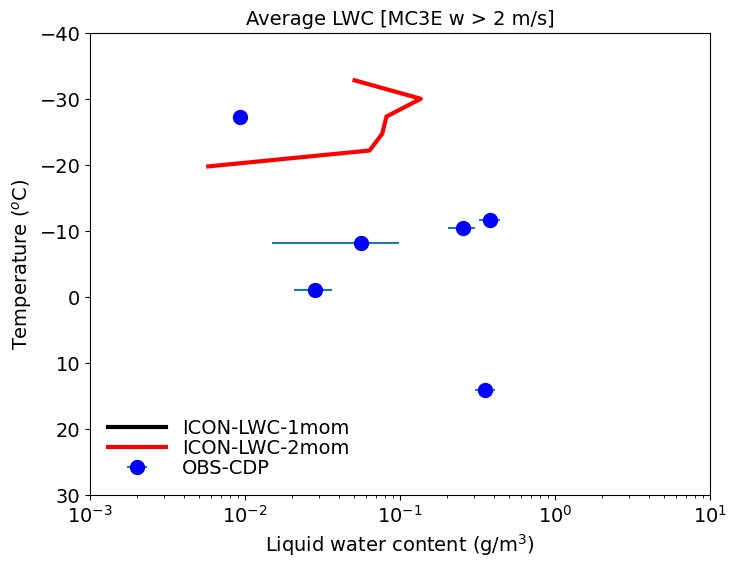

In [145]:
# Plotting
plt.figure(figsize=(8, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=14
plt.plot(avg_lwc_1mom,avg_temp_1mom-273.16, 'k-', label='ICON-LWC-1mom', linewidth = lnwdth)
plt.plot(avg_lwc_2mom,avg_temp_2mom-273.16, 'r-', label='ICON-LWC-2mom', linewidth = lnwdth)
plt.errorbar(lwc_cdp, temp_obs_cdp, xerr=std_err_lwc_cdp, fmt='o' , label='OBS-CDP', markersize=10,
             markeredgecolor='b', markerfacecolor='b', capsize=0)

# Setting plot limits and labels
plt.xlim(1.e-3, 1.e1)
plt.xticks([1.e-3,1.e-2,1.e-1,1.e1,1.e0,1.e1], fontsize=fontsize)
plt.ylim(30, -40)
plt.yticks([30,20,10,0,-10,-20,-30,-40], fontsize=fontsize)
# Set x-axis to logarithmic scale
plt.xscale('log')
plt.xlabel('Liquid water content (g/m$^{3}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('Average LWC [MC3E w > 2 m/s]', fontsize=fontsize)
plt.legend()
# Increase the length of dashes in the legend
plt.legend(frameon=False, handlelength=3, labelspacing=0.05, fontsize=fontsize, loc='lower left')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)
#plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/mc3e/plots/mc3e_lwc_1mom.jpg', dpi=400, bbox_inches='tight')

plt.show()

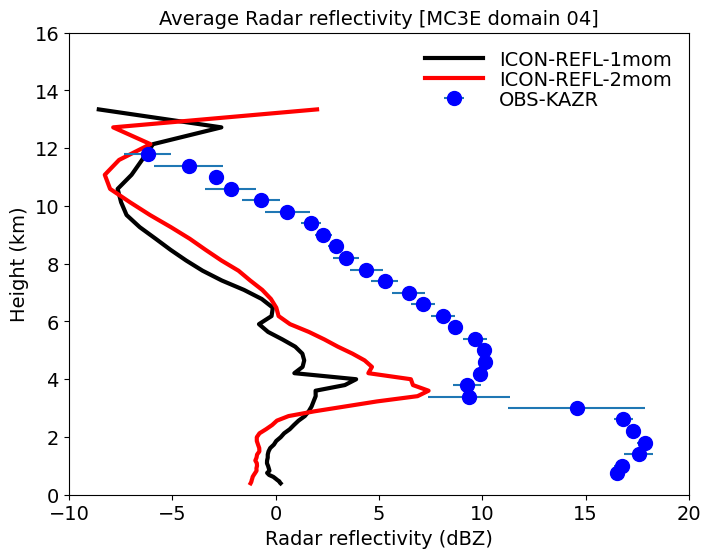

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import matplotlib.dates as mdates
from datetime import datetime
import xarray as xr
import netCDF4 as nc
import pandas as pd
import glob
import math
import subprocess
from matplotlib import colormaps

# Plotting
plt.figure(figsize=(8, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=14
plt.plot(avg_dbz_1mom,avg_ht_1mom/1000., 'k-', label='ICON-REFL-1mom', linewidth = lnwdth)
plt.plot(avg_dbz_2mom,avg_ht_2mom/1000., 'r-', label='ICON-REFL-2mom', linewidth = lnwdth)
plt.errorbar(refl_kazr_obs, alt_kazr_obs/1000., xerr=std_err_refl_kazr_obs, fmt='o' , label='OBS-KAZR', markersize=10,
             markeredgecolor='b', markerfacecolor='b', capsize=0)

# Setting plot limits and labels
plt.xlim(-10,20)
plt.xticks([-10,-5,0,5,10,15,20], fontsize=fontsize)
plt.ylim(0, 16)
plt.yticks([0,2,4,6,8,10,12,14,16], fontsize=fontsize)
# Set x-axis to logarithmic scale
#plt.xscale('log')
plt.xlabel('Radar reflectivity (dBZ)', fontsize=fontsize)
plt.ylabel('Height (km)', fontsize=fontsize)
plt.title('Average Radar reflectivity [MC3E domain 04]', fontsize=fontsize)
plt.legend()
# Increase the length of dashes in the legend
plt.legend(frameon=False, handlelength=3, labelspacing=0.05, fontsize=fontsize, loc='upper right')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)
#plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/mc3e/plots/mc3e_refl_dom01.jpg', dpi=600, bbox_inches='tight')

plt.show()

In [20]:

time_citation_obs = []
temp_citation_obs = []
lat_citation_obs = []
lon_citation_obs = []
alt_citation_obs = []

with open('/work/bb1163/b382718/output/mc3e/observations/FORTRAN_CODE/ICE_CONC_VERTICAL_PROFILE/UPDRAFT/OUTPUT/raw_time_lat_lon_profile_mc3e', 'r') as file:
    # Read each line
    for line in file:
        # Split the line into columns (assuming columns are separated by whitespace)
        columns = line.split()
        # Store each column in its corresponding list
        time_citation_obs.append(float(columns[0]))
        temp_citation_obs.append(float(columns[1]))
        lat_citation_obs.append(float(columns[2]))
        lon_citation_obs.append(float(columns[3]))
        alt_citation_obs.append(float(columns[3]))

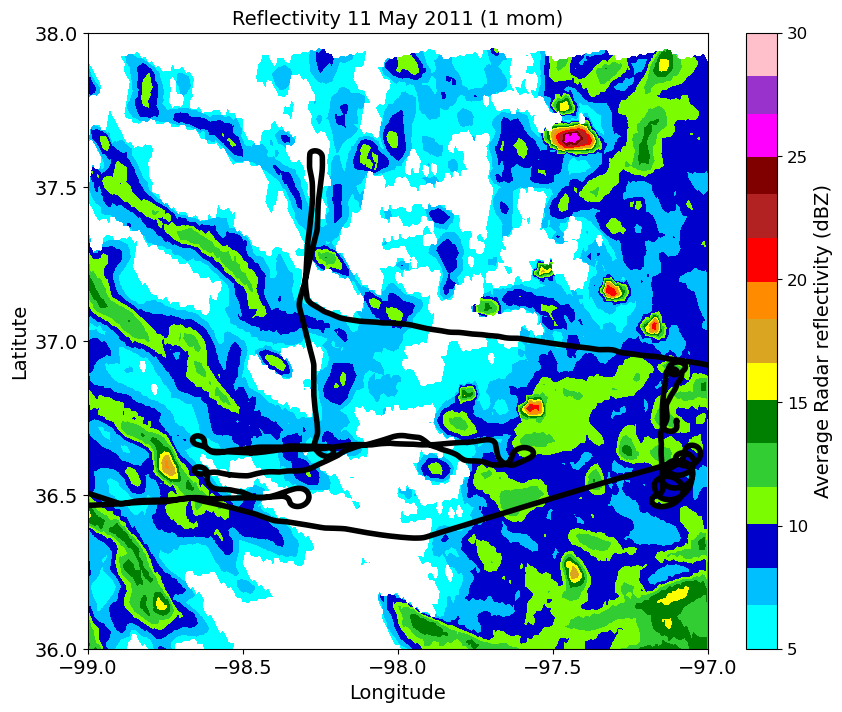

In [20]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

ds = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/1_mom/NWP_LAM_DOM04_20110511T*Z.nc")
grid = xr.open_dataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/1_mom/domain4_DOM04.nc")


mask_cell=np.isin(ds_mc3e_1mom.dbz['ncells'], selected_indices.cell)
ds_new = ds.sel(ncells=mask)
grid_new = grid.sel(cell=mask)

#
filtered_dbz = xr.where((ds_new.dbz > 5.), ds_new.dbz, np.nan)

# Calculate the mean: time and height dimensions
avg_dbz = filtered_dbz.mean(dim=('time', 'height'))
#avg_dbz = ds_new.dbz.mean(dim=('time', 'height'))

# Extract longitude and latitude
clon_deg = np.degrees(grid_new.clon)
clat_deg = np.degrees(grid_new.clat)

# Set NaN values to a value outside the range of the colormap
masked_dbz = np.where(np.isnan(avg_dbz), -9999, avg_dbz)

# Define the colors
colors = ['cyan', 'deepskyblue', 'mediumblue', 'lawngreen', 'limegreen', 'green', 'yellow', 'goldenrod', 
          'darkorange', 'red', 'firebrick', 'maroon', 'magenta', 'darkorchid', 'pink']


plt.figure(figsize=(10, 8))
# Create a ListedColormap with the specified colors
cmap = ListedColormap(colors)

# Plot the contour

plt.plot(lon_citation_obs,lat_citation_obs, 'k-', label='Citation aircraft', linewidth = 4)
contour = plt.tricontourf(clon_deg, clat_deg, masked_dbz, cmap=cmap, levels=np.linspace(5, 30, 100))
colorbar = plt.colorbar(contour, ticks=[5, 10, 15, 20, 25, 30], label='Average Radar reflectivity (dBZ)')
colorbar.ax.tick_params(labelsize=12)
colorbar.set_label(label='Average Radar reflectivity (dBZ)', size=14)
plt.xlim([-99, -97]); 
plt.ylim([36, 38]); 
plt.xticks([-99,-98.5,-98,-97.5,-97], fontsize=14)
plt.yticks([36,36.5,37,37.5,38], fontsize=14)
plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitute',fontsize=14)
plt.title('Reflectivity 11 May 2011 (1 mom)',fontsize=14)
#plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/mc3e/plots/mc3e_lat_lon_refl_dom04_1mom.jpg', dpi=600, bbox_inches='tight')
#Set the color for NaN values to be transparent
#contour.set_hatches([''])  
plt.show()



<xarray.DataArray 'dbz' ()>
array(-150.)
<xarray.DataArray 'dbz' ()>
array(37.57986832)


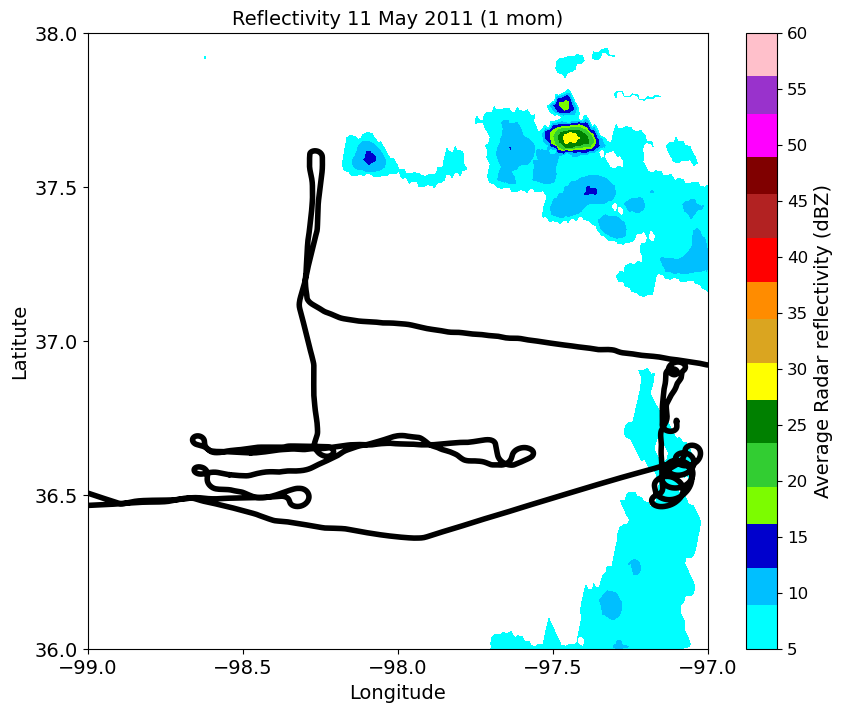

In [26]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

ds = xr.open_dataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/old_1_2mom/1_mom/NWP_LAM_DOM04_20110511T203000Z.nc")
grid = xr.open_dataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/old_1_2mom/1_mom/domain4_DOM04.nc")



mask_cell=np.isin(ds.dbz['ncells'], selected_indices.cell)
ds_new = ds.sel(ncells=mask)
grid_new = grid.sel(cell=mask)

#
filtered_dbz = xr.where((ds_new.dbz > 5.), ds_new.dbz, np.nan)

print('===========================================')
print(ds_new.dbz.min())
print(ds_new.dbz.max())
print('===========================================')
# Calculate the mean: time and height dimensions
avg_dbz = filtered_dbz.mean(dim=('time', 'height'))
#avg_dbz = ds_new.dbz.mean(dim=('time', 'height'))

print('===========================================')
#print(avg_dbz.values)
print('===========================================')

# Extract longitude and latitude
clon_deg = np.degrees(grid_new.clon)
clat_deg = np.degrees(grid_new.clat)

# Set NaN values to a value outside the range of the colormap
masked_dbz = np.where(np.isnan(avg_dbz), 0., avg_dbz)

# Define the colors
colors = ['cyan', 'deepskyblue', 'mediumblue', 'lawngreen', 'limegreen', 'green', 'yellow', 'goldenrod', 
          'darkorange', 'red', 'firebrick', 'maroon', 'magenta', 'darkorchid', 'pink']


plt.figure(figsize=(10, 8))
# Create a ListedColormap with the specified colors
cmap = ListedColormap(colors)

# Plot the contour

plt.plot(lon_citation_obs,lat_citation_obs, 'k-', label='Citation aircraft', linewidth = 4)
contour = plt.tricontourf(clon_deg, clat_deg, masked_dbz, cmap=cmap, levels=np.linspace(5, 60, 100))
colorbar = plt.colorbar(contour, ticks=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60], label='Average Radar reflectivity (dBZ)')
colorbar.ax.tick_params(labelsize=12)
colorbar.set_label(label='Average Radar reflectivity (dBZ)', size=14)
plt.xlim([-99, -97]); 
plt.ylim([36, 38]); 
plt.xticks([-99,-98.5,-98,-97.5,-97], fontsize=14)
plt.yticks([36,36.5,37,37.5,38], fontsize=14)
plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitute',fontsize=14)
plt.title('Reflectivity 11 May 2011 (1 mom)',fontsize=14)
#plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/mc3e/plots/mc3e_lat_lon_refl_dom04_1mom.jpg', dpi=600, bbox_inches='tight')
#Set the color for NaN values to be transparent
#contour.set_hatches([''])  
plt.show()





<xarray.DataArray 'dbz' ()>
array(-150.)
<xarray.DataArray 'dbz' ()>
array(12.90189362)


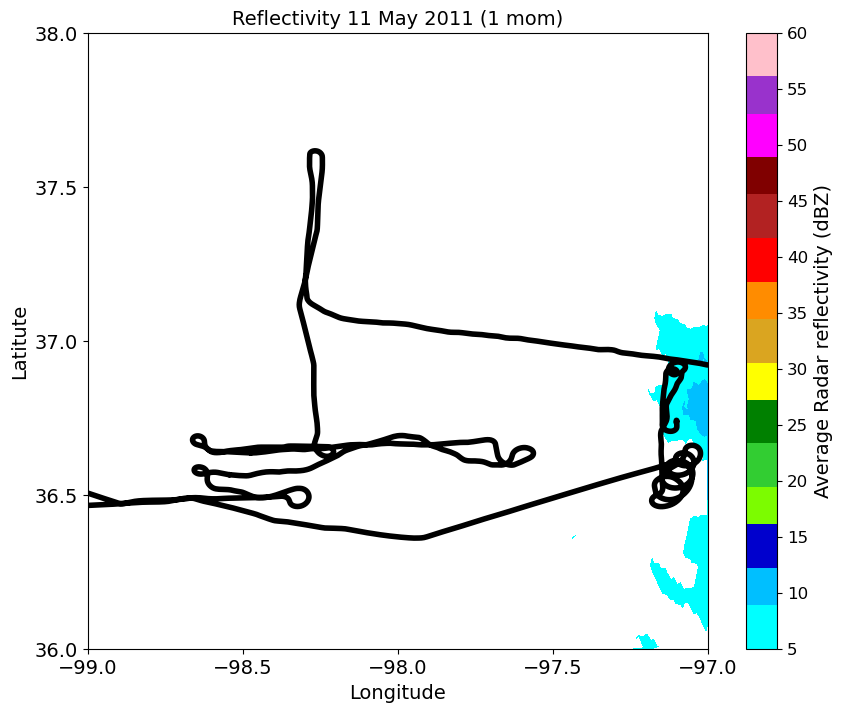

In [27]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

ds = xr.open_dataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/old_1_2mom/1_mom/NWP_LAM_DOM04_20110511T223000Z.nc")
grid = xr.open_dataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/old_1_2mom/1_mom/domain4_DOM04.nc")



mask_cell=np.isin(ds.dbz['ncells'], selected_indices.cell)
ds_new = ds.sel(ncells=mask)
grid_new = grid.sel(cell=mask)

#
filtered_dbz = xr.where((ds_new.dbz > 5.), ds_new.dbz, np.nan)

print('===========================================')
print(ds_new.dbz.min())
print(ds_new.dbz.max())
print('===========================================')
# Calculate the mean: time and height dimensions
avg_dbz = filtered_dbz.mean(dim=('time', 'height'))
#avg_dbz = ds_new.dbz.mean(dim=('time', 'height'))

print('===========================================')
#print(avg_dbz.values)
print('===========================================')

# Extract longitude and latitude
clon_deg = np.degrees(grid_new.clon)
clat_deg = np.degrees(grid_new.clat)

# Set NaN values to a value outside the range of the colormap
masked_dbz = np.where(np.isnan(avg_dbz), 0., avg_dbz)

# Define the colors
colors = ['cyan', 'deepskyblue', 'mediumblue', 'lawngreen', 'limegreen', 'green', 'yellow', 'goldenrod', 
          'darkorange', 'red', 'firebrick', 'maroon', 'magenta', 'darkorchid', 'pink']


plt.figure(figsize=(10, 8))
# Create a ListedColormap with the specified colors
cmap = ListedColormap(colors)

# Plot the contour

plt.plot(lon_citation_obs,lat_citation_obs, 'k-', label='Citation aircraft', linewidth = 4)
contour = plt.tricontourf(clon_deg, clat_deg, masked_dbz, cmap=cmap, levels=np.linspace(5, 60, 100))
colorbar = plt.colorbar(contour, ticks=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60], label='Average Radar reflectivity (dBZ)')
colorbar.ax.tick_params(labelsize=12)
colorbar.set_label(label='Average Radar reflectivity (dBZ)', size=14)
plt.xlim([-99, -97]); 
plt.ylim([36, 38]); 
plt.xticks([-99,-98.5,-98,-97.5,-97], fontsize=14)
plt.yticks([36,36.5,37,37.5,38], fontsize=14)
plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitute',fontsize=14)
plt.title('Reflectivity 11 May 2011 (1 mom)',fontsize=14)
#plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/mc3e/plots/mc3e_lat_lon_refl_dom04_1mom.jpg', dpi=600, bbox_inches='tight')
#Set the color for NaN values to be transparent
#contour.set_hatches([''])  
plt.show()





(61, 65, 141784)
('time', 'height', 'ncells')
('time', 'height')


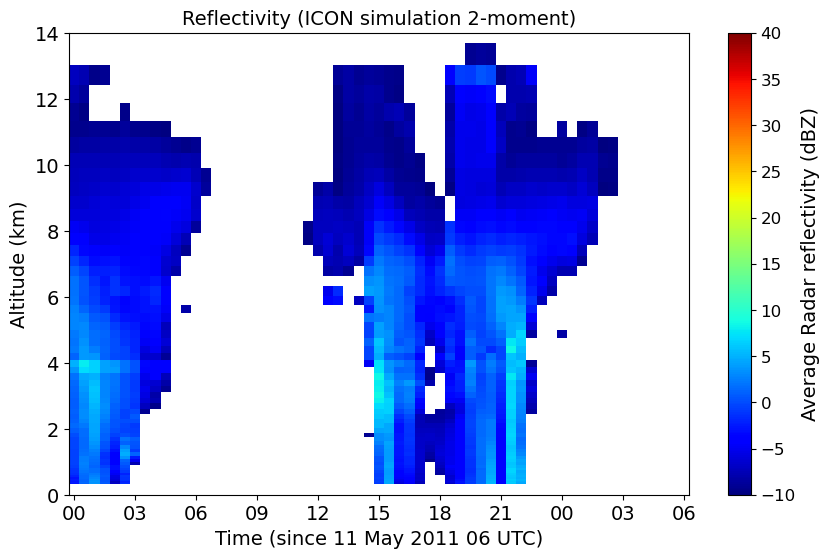

In [28]:
import netCDF4 as nc

ds_11may = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/old_1_2mom/1_mom/NWP_LAM_DOM04_20110511T*Z.nc")
ds_12may = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/old_1_2mom/1_mom/NWP_LAM_DOM04_20110512T*Z.nc")

data_mc3e = xr.concat([ds_11may, ds_12may], dim="time")

mask_cell=np.isin(data_mc3e.qc['ncells'], selected_indices.cell)
ds_new = data_mc3e.sel(ncells=mask)
grid_new = grid.sel(cell=mask)

filtered_dbz = xr.where((ds_new.dbz > -10.), ds_new.dbz, np.nan)

time_new = data_mc3e["time"];
dbz_new = data_mc3e["dbz"];
ht_new = data_mc3e["z_mc"];

print(ht_new.shape)
avg_dbz_new = filtered_dbz.mean("ncells")
avg_ht_new = 1.e-3*ht_new.mean(dim=('time','ncells'))

print(filtered_dbz.dims)
print(avg_dbz_new.dims)
#print(time_new.values)

#plot
#plt.figure(figsize=(10, 6))
#plt.pcolormesh(time_new, avg_ht_new, avg_dbz_new.T, cmap='jet')
#plt.colorbar(label='Reflectivity (dBZ)')
#plt.ylim([0, 14]); 
#plt.yticks([0,2,4,6,8,10,12,14], fontsize=14)
#plt.xlabel('Time')
#plt.ylabel('Altitude (m)')
#plt.title('Reflectivity over Time and Altitude')
##plt.gca().invert_yaxis()  # Invert y-axis to have increasing altitude upwards
#plt.show()


plt.figure(figsize=(10, 6))
contour=plt.pcolormesh(time_new, avg_ht_new, avg_dbz_new.T, cmap='jet', vmin=-10, vmax=40)
colorbar = plt.colorbar(contour, ticks=[-10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40], label='Average Radar reflectivity (dBZ)')
colorbar.ax.tick_params(labelsize=12)
colorbar.set_label(label='Average Radar reflectivity (dBZ)', size=14)
plt.xlabel('Time (since 11 May 2011 06 UTC)', fontsize=14)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Format to show only hours
plt.xticks(fontsize=14)
plt.ylim([0, 14]); 
plt.yticks([0,2,4,6,8,10,12,14], fontsize=14)
plt.ylabel('Altitude (km)', fontsize=14)
plt.title('Reflectivity (ICON simulation 2-moment)', fontsize=14)
#plt.gca().invert_yaxis()  # Invert y-axis to have increasing altitude upwards
plt.show()

0.0
0.0011126109


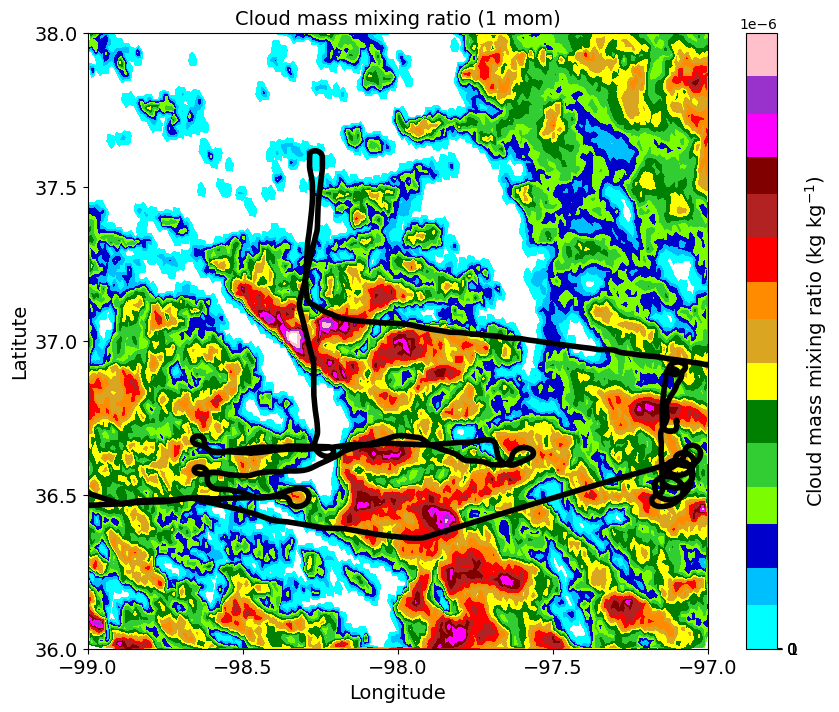

In [23]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

ds = xr.open_dataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/old_1_2mom/1_mom/NWP_LAM_DOM04_20110511T163000Z.nc")
grid = xr.open_dataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/old_1_2mom/1_mom/domain4_DOM04.nc")


mask_cell=np.isin(ds_mc3e_1mom.qc['ncells'], selected_indices.cell)
ds_new = ds.sel(ncells=mask)
grid_new = grid.sel(cell=mask)

#
filtered_qc = xr.where((ds_new.qc > 1.e-6), ds_new.qc, np.nan)

# Calculate the mean: time and height dimensions
avg_qc = filtered_qc.mean(dim=('time', 'height'))
#avg_dbz = ds_new.dbz.mean(dim=('time', 'height'))

# Extract longitude and latitude
clon_deg = np.degrees(grid_new.clon)
clat_deg = np.degrees(grid_new.clat)

# Set NaN values to a value outside the range of the colormap
masked_qc = np.where(np.isnan(avg_qc), 0., avg_qc)

# Define the colors
colors = ['cyan', 'deepskyblue', 'mediumblue', 'lawngreen', 'limegreen', 'green', 'yellow', 'goldenrod', 
          'darkorange', 'red', 'firebrick', 'maroon', 'magenta', 'darkorchid', 'pink']


plt.figure(figsize=(10, 8))
# Create a ListedColormap with the specified colors
cmap = ListedColormap(colors)

print(masked_qc.min())
print(masked_qc.max())
# Plot the contour

plt.plot(lon_citation_obs,lat_citation_obs, 'k-', label='Citation aircraft', linewidth = 4)
contour = plt.tricontourf(clon_deg, clat_deg, masked_qc, cmap=cmap, levels=np.linspace(1.e-10, 1.e-3, 100))
colorbar = plt.colorbar(contour, ticks=[1.e-10,1.e-8,1.e-6,1.e-2], label='Cloud mass mixing ratio (kg kg$^{-1}$)')
colorbar.ax.tick_params(labelsize=12)
colorbar.set_label(label='Cloud mass mixing ratio (kg kg$^{-1}$)', size=14)
plt.xlim([-99, -97]); 
plt.ylim([36, 38]); 
plt.xticks([-99,-98.5,-98,-97.5,-97], fontsize=14)
plt.yticks([36,36.5,37,37.5,38], fontsize=14)
plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitute',fontsize=14)
plt.title('Cloud mass mixing ratio (1 mom)',fontsize=14)
#plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/mc3e/plots/mc3e_lat_lon_refl_dom04_1mom.jpg', dpi=600, bbox_inches='tight')
#Set the color for NaN values to be transparent
#contour.set_hatches([''])  
plt.show()



In [211]:
print(clon_deg.shape)
print(masked_dbz.shape)

(22952,)
(48, 65)


In [215]:
print(avg_ht.shape)
print(masked_dbz.shape)
print(ds_new.time.shape)

(65,)
(48, 65)
(48,)


In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

ds = xr.open_dataset("/work/bb1163/b382718/output/mc3e/icon_input/input_data/2011051000_2011051400/e5_initicon_2011051000.nc")


In [21]:
print(ds.lon.shape)
print(ds.lat.shape)

print(ds.lon[1].values)
print(ds.lon[2].values)

print(ds.lat[1].values)
print(ds.lat[2].values)


(1280,)
(640,)
0.28125
0.5625
89.50620273820637
89.22588284761157


In [25]:
ds

<xarray.Dataset>
Dimensions:       (time: 1, lon: 1280, lat: 640, lev: 137, nhyi: 138,
                   nhym: 137, lev_2: 1, depth: 1, bnds: 2, depth_2: 1,
                   depth_3: 1, depth_4: 1)
Coordinates:
  * time          (time) datetime64[ns] 2011-05-10
  * lon           (lon) float64 0.0 0.2812 0.5625 0.8438 ... 359.2 359.4 359.7
  * lat           (lat) float64 89.78 89.51 89.23 88.95 ... -89.23 -89.51 -89.78
  * lev           (lev) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * lev_2         (lev_2) float64 1.0
  * depth         (depth) float64 0.0
  * depth_2       (depth_2) float64 7.0
  * depth_3       (depth_3) float64 28.0
  * depth_4       (depth_4) float64 100.0
Dimensions without coordinates: nhyi, nhym, bnds
Data variables: (12/45)
    hyai          (nhyi) float64 ...
    hybi          (nhyi) float64 ...
    hyam          (nhym) float64 ...
    hybm          (nhym) float64 ...
    depth_bnds    (depth, bnds) float64 ...
    depth_2_bnds  (depth_2, bnds) float64 ...
    ...            ...
    slor          (time, lat, lon) float32 ...
    slt           (time, lat, lon) float32 ...
    swvl1         (time, depth, lat, lon) float32 ...
    swvl2         (time, depth_2, lat, lon) float32 ...
    swvl3         (time, depth_3, lat, lon) float32 ...
    swvl4         (time, depth_4, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.2.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Fri Mar 15 14:40:02 2024: cdo -f nc copy e5_initicon_201105...
    CDO:          Climate Data Operators version 2.2.2 (https://mpimet.mpg.de...